# IRCUR

Paper: https://arxiv.org/pdf/2010.07422.pdf

Matlab Script: https://github.com/caesarcai/IRCUR/blob/master/IRCUR.m

Full Repository: https://github.com/caesarcai/IRCUR

Related paper that is more recent: https://arxiv.org/pdf/2206.09042.pdf (on Riemannian CUR)

In [1]:
import numpy as np
from numpy import linalg as LA
import random
from scipy.optimize import minimize
import matplotlib.pyplot as plt
import os
import torch
from torch import nn
from torch.optim import Adam
from torch.optim import SGD
import math

np.random.seed(0)
torch.manual_seed(0)

In [9]:
## ======================== Parameters ========================
d1 = 100                   # num. of rows
d2 = 70                   # num. of columns
max_iter = 100              # num. of layers trained

In [3]:
## Code to generate data for RPCA problem. References:
## https://github.com/caesarcai/LRPCA/blob/main/synthetic_data_exp/training_codes.py 
## https://github.com/caesarcai/AccAltProj_for_RPCA/blob/master/test_AccAltProj.m

def generate_problem(r,d1,d2,alpha):
    U0_t 		= torch.randn(d1,r)
    V0_t 		= torch.randn(d2,r)
    idx 		= torch.randperm(d1*d2)
    idx 		= idx[:math.floor(alpha * d1*d2)]
    L0_t 		= torch.mm(U0_t,V0_t.t())
    s_range		= torch.mean(torch.abs(L0_t))
    S0_tmp 		= torch.rand(len(idx))
    S0_tmp 		= s_range * (2.0 * S0_tmp - 1.0)
    S0_t        = torch.zeros(d1 * d2)
    S0_t[idx]   = S0_tmp
    S0_t        = S0_t.reshape((d1,d2))
    Y0_t        = L0_t + S0_t
    return L0_t, S0_t, Y0_t

In [22]:
## ======================== Learned AccAltProj model ========================
## recover low-rank matrix L from M = L + S

# ======================== One Layer of the NN ========================
class AltProj(nn.Module):
    def __init__(self):
        super().__init__()
        self.gamma = nn.Parameter(torch.tensor(0.7)) # parameter for sparse component, follows the value used in matlab script (line 39)
        self.ths_sv = nn.Parameter(torch.tensor(1.0)) # parameter for low rank component

    ## resampling function, follows lines 123-126 of the Matlab script
    def resample(self, m, n, siz_row, siz_col):
        rows = np.random.randint(0, m, size=[1, siz_row])
        cols = np.random.randint(0, n, size=[1, siz_col])
        return [np.unique(rows), np.unique(cols)]
    
    ## soft-thresholding operator
    def softThres(self, inputs, threshold):
        out = torch.sign(inputs) * torch.maximum(torch.abs(inputs)- threshold, torch.zeros([1,1]))
        return out

    def forward(self, M0, C, pinv_U, R, siz_row, siz_col, zeta_init):
        ## resample rows and columns
        m, n = M0.shape
        rows, cols = self.resample(m, n, siz_row, siz_col)
        M0_rows = M0[rows, :]
        M0_cols = M0[:, cols]
        norm_of_M0 = torch.linalg.norm(M0_rows) + torch.linalg.norm(M0_cols)
        ## compute submatrices of L from previous iteration
        L_rows = C[rows, :] @ pinv_U @ R
        L_cols = C @ pinv_U @ R[:, cols]
        ## update S using submatrices of L
        S_rows = M0_rows - L_rows
        S_rows = self.softThres(S_rows, self.gamma * zeta_init)
        S_cols = M0_cols - L_cols
        S_cols = self.softThres(S_cols, self.gamma * zeta_init)
        ## update L
        C = M0_cols - S_cols
        R = M0_rows - S_rows
        MU = C[rows, :]
        U,Sigma,V = torch.linalg.svd(MU)
        ## calculate Moore-Penrose inverse of Sigma
        Sigma_inv = torch.zeros(size=Sigma.shape)
        mask = (Sigma != 0)
        Sigma_inv[mask] = torch.div(1, Sigma[mask])
        ## I soft-thresholded the values here, in the original algorithm it should be truncated at the rth value
        Sigma_inv = self.softThres(Sigma_inv, self.ths_sv).flatten()
        pinv_U = V[:, :min(V.shape[1], U.shape[1])] @ torch.diag(Sigma_inv) @ U[:, :min(V.shape[1], U.shape[1])].t()
        ## compute err using previous L and current S, as done in the matlab script (lines 160-162)
        loss = (torch.linalg.norm(M0_rows - L_rows - S_rows) + torch.linalg.norm(M0_cols - L_cols - S_cols))/ norm_of_M0
        return C, pinv_U, R, loss

## ======================== Full NN with layers stacked ========================
class LearnedIRCUR(nn.Module):
    def __init__(self, max_iter):
        super().__init__()
        self.max_iter = max_iter
        self.layer=[]
        for i in range(max_iter):
            self.layer.append(AltProj())
        self.layers=nn.Sequential(*self.layer) ## stack layers together
        self.loss=np.zeros(max_iter)
    
    def forward(self, M0, r, con): 
        ## r (rank) and con (constant between 3 and 5) needed to estimate number of rows and cols sampled
        ## sampling size = O(rlog(n)) = con * r * log(n) by Theorem 4 (page 3) of the paper
        ## sampling constant con is between 3 and 5 from numerical results (Section 4, page 7-8)
        m, n = M0.shape
        siz_row, siz_col = np.ceil(con * r * np.log(m)).astype(np.int64), np.ceil(con * r * np.log(n)).astype(np.int64)
        ## start with L0 = C @ pinv_U @ R = 0
        C, pinv_U, R = torch.zeros(M0.shape), torch.zeros([M0.shape[1], M0.shape[0]]), torch.zeros(M0.shape)
        ## initialize threshold for updating sparse component
        zeta_init = torch.max(torch.abs(M0)) ## follows matlab script (line 38) and Section 3.5 (page 6) of paper
        for i in range(self.max_iter):
            lay = self.layers[i]
            C, pinv_U, R, self.loss[i] = lay(M0, C, pinv_U, R, siz_row, siz_col, zeta_init)
        return C, pinv_U, R

In [24]:
L_true, S_true, M_true = generate_problem(5, d1, d2, 0.3)

In [25]:
net = LearnedIRCUR(max_iter)
beforetrain=net(M_true, 5, 3) # assumes knowledge of rank = 5, and sampling constant chosen as 3
lossbftrain=np.array(net.loss)

In [ ]:
optimizer=Adam(net.parameters())

nepochs = 20 
train_sample = 100
for epoch in range(nepochs):  # loop over the dataset multiple times

    for i in range(train_sample):
        # get the inputs; data is a list of [inputs, groundtruth]
        L0, S0, M0 = generate_problem(5, d1, d2, 0.3)
        # zero the parameter gradients
        optimizer.zero_grad()
        C, pinv_U, R = net(M0, 5, 3)
        L_hat = C@pinv_U@R
        loss = torch.linalg.norm(L_hat - L0)
        # loss = (C@pinv_U@R - L0).norm() ## Frobenius norm of estimated L - L0, to be changed afterwards
        loss.backward()
        optimizer.step()
    
    print('Epoch ' + str(epoch+1) +'/' + str(nepochs) +' at cost=' + str(round(loss.item(),3)))

print('Finished Training')

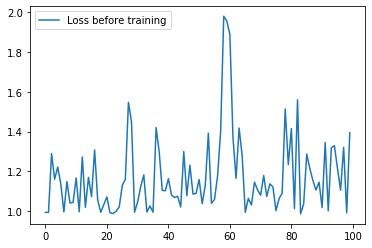

In [28]:
#output = net(M_true, 5, 4)
#plt.plot(range(max_iter),net.loss,'r:',label='Loss after training')
plt.plot(range(max_iter),lossbftrain,label='Loss before training')
plt.legend()
plt.show()